<a href="https://colab.research.google.com/github/ameyaa/makemore/blob/main/makemore_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
print(words[:5])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia']
32033


In [3]:
# vocabulary of chars in dataset and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {c:i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
SZ = len(stoi)
itos = {i:c for c, i in stoi.items()}
print(itos)
print('SZ: ', SZ)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
SZ:  27


In [28]:
# build the dataset
block_sz = 3
X, Y = [], []
for w in words[:5]:
  #print(w)
  context = [0] * block_sz
  for c in w + '.':
    ix = stoi[c]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '----->', itos[ix])
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [7]:
# embeddings - embed 27 possible chars into 2-dimensional space
C = torch.randn((SZ, 2))  # aka lookup table
C

tensor([[ 2.5818,  0.7043],
        [ 1.1413,  1.7492],
        [ 0.2720,  0.7449],
        [ 0.8358,  0.5823],
        [ 0.3671,  0.2646],
        [-0.2085, -0.5919],
        [ 2.4613, -0.0389],
        [ 0.1049, -0.3816],
        [ 0.7340,  0.5385],
        [-0.6747,  0.3571],
        [ 0.0959,  1.5440],
        [-1.0823,  1.1823],
        [-1.0089,  1.0433],
        [-1.4333,  0.9344],
        [-0.5669, -0.2335],
        [ 0.6501,  0.7354],
        [-1.4235,  2.5106],
        [ 1.2518,  0.6631],
        [-0.8436, -0.5613],
        [-0.1764,  0.7845],
        [-0.2700, -0.0468],
        [ 0.3697,  1.1647],
        [ 0.1408, -0.4262],
        [ 1.6436,  1.6997],
        [ 2.0265,  0.6387],
        [ 0.2634,  0.4009],
        [-0.3915,  0.1857]])

In [8]:
# Example - how to embed an integer 5 into 27 x 2 dimensional tensor
print(C[5])  # method 1 - simpler/faster/preferred
# method 2 - dot product
oh = F.one_hot(torch.tensor(5), num_classes=SZ).float()
print(oh)
oh @ C

tensor([-0.2085, -0.5919])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])


tensor([-0.2085, -0.5919])

In [9]:
# how to embed X in C --> just do C[X]
print('C shape: ', C.shape)
print('X shape: ', X.shape)
print('C[X] shape: ', C[X].shape)
print(X[13])
print(X[13,2])
print(C[X][13])
print(C[X][13,2])

C shape:  torch.Size([27, 2])
X shape:  torch.Size([32, 3])
C[X] shape:  torch.Size([32, 3, 2])
tensor([0, 0, 1])
tensor(1)
tensor([[2.5818, 0.7043],
        [2.5818, 0.7043],
        [1.1413, 1.7492]])
tensor([1.1413, 1.7492])


In [10]:
# embed input X into C
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [11]:
# layer 2 - hidden activation layer
# inputs to hidden layer: 3 x 2 = 6 (2-dimensional embedding and 3 of them)
num_neurons = 100
W1 = torch.randn((6, num_neurons))
b1 = torch.randn(num_neurons)

In [12]:
# The following is what we want to do
emb @ W1 + b1
# But it will error out since  emb (32 x 3 x 2) and W1 (6 x 100) are not compatible

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [13]:
# To fix the above error, we need to concatenate the (3 x 2 = 6 ) entries --> 32 x 3 x 2 --> 32 x 6
print(emb[:, 0, :].shape)
torch.cat((emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]), 1).shape
# Above code assumes block_size of 3 (0, 1, 2), so won't work if we change block_size

torch.Size([32, 2])


torch.Size([32, 6])

In [14]:
# Use unbind to fix above issue
# The following code is independent of block_size
ub = torch.unbind(emb, 1)
print(len(ub))
for i in range(len(ub)):
  print(ub[i].shape)
torch.cat(ub, 1).shape

3
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])


torch.Size([32, 6])

In [15]:
# Alternative to unbind
a = torch.arange(6)
print(a)
print(a.view(3, 2))
print(a.view(2, 3))
# View doesn't reallocate new memory, but merely changes how the tensor is 'viewed'
print(emb.shape)
emb.view(32, 6).shape

tensor([0, 1, 2, 3, 4, 5])
tensor([[0, 1],
        [2, 3],
        [4, 5]])
tensor([[0, 1, 2],
        [3, 4, 5]])
torch.Size([32, 3, 2])


torch.Size([32, 6])

In [16]:
# Using .view instead of unbind
h = emb.view(emb.shape[0], emb.shape[1]*emb.shape[2]) @ W1 + b1
print(h.shape)
h

torch.Size([32, 100])


tensor([[ 4.0123, -5.3781, -0.6281,  ...,  2.5347, -3.0528, -3.2458],
        [ 0.2079,  3.6088,  0.2534,  ...,  1.1857, -5.7334, -6.4016],
        [-1.6016,  1.6077, -4.1203,  ...,  0.3566,  1.4085, -4.7458],
        ...,
        [ 1.0752, -8.1031, -2.0179,  ...,  0.2810, -0.2862, -1.2383],
        [-4.6485,  2.3589,  0.4298,  ...,  1.8078, -1.1828,  0.6581],
        [ 1.0247, -7.1335, -3.4627,  ...,  1.5676,  3.6929,  0.6161]])

In [17]:
# Slight variation in using .view (compared to above cell)
h = emb.view(-1, emb.shape[1]*emb.shape[2]) @ W1 + b1  # with -1, torch infers that dimension (in this case, 32)
print(h.shape)

torch.Size([32, 100])


In [18]:
# Double check if broadcasting is working correctly in the matrix multiplication/addition
p = emb.view(-1, emb.shape[1]*emb.shape[2]) @ W1
print(p.shape)
print(b1.shape)
# 32 x 100
# 100
#      100  broadcasting will align 100 to right
# 1  x 100  create fake dimension 1 on left to get a row vector
# Do row-wise addition. So the same bias-vector will be added element-wise to the rows.
# This is what we want

torch.Size([32, 100])
torch.Size([100])


In [19]:
# Now apply tanh activation. Each element will be between [-1, 1] inclusive
h = torch.tanh(p + b1)
print(h.shape)
h

torch.Size([32, 100])


tensor([[ 0.9993, -1.0000, -0.5567,  ...,  0.9875, -0.9955, -0.9970],
        [ 0.2049,  0.9985,  0.2481,  ...,  0.8293, -1.0000, -1.0000],
        [-0.9219,  0.9228, -0.9995,  ...,  0.3422,  0.8872, -0.9998],
        ...,
        [ 0.7914, -1.0000, -0.9653,  ...,  0.2739, -0.2786, -0.8450],
        [-0.9998,  0.9823,  0.4051,  ...,  0.9476, -0.8283,  0.5771],
        [ 0.7718, -1.0000, -0.9980,  ...,  0.9166,  0.9988,  0.5484]])

In [20]:
# layer 3 - softmax layer
print(h.shape[1])
print(SZ)
W2 = torch.randn(h.shape[1], SZ)
b2 = torch.randn(SZ)
print(W2.shape, b2.shape)

100
27
torch.Size([100, 27]) torch.Size([27])


In [21]:
# Calculate logits
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [22]:
# exponentiate to get fake counts
counts = logits.exp()
counts.shape

torch.Size([32, 27])

In [23]:
# compute probabilities
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([32, 27])

In [24]:
# print the actual Y values
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [25]:
# infer the predicted Y values from the probabilites
print(torch.arange(prob.shape[0]))
Y_pred = prob[torch.arange(prob.shape[0]), Y]
print(Y_pred)  # the probability for the index corresponding to actual Y values
# we haven't trained the model yet, ideal values for the probability would be 1

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])
tensor([9.8972e-01, 3.2911e-04, 2.3336e-13, 5.2675e-11, 1.1423e-11, 1.4155e-10,
        6.0805e-10, 1.3139e-06, 3.0485e-11, 6.1050e-02, 3.0722e-10, 2.1925e-12,
        3.0432e-07, 6.8736e-14, 2.1394e-03, 2.9485e-09, 2.6078e-09, 9.9535e-11,
        1.4983e-08, 4.7424e-09, 4.4171e-03, 5.1293e-11, 1.5015e-16, 1.0380e-13,
        1.8272e-14, 4.8858e-09, 4.6696e-12, 1.7996e-02, 3.1002e-16, 2.5006e-03,
        1.3060e-09, 2.2847e-12])


In [26]:
# calculate the loss - remember, loss is to be minimized
loss = -Y_pred.log().mean()
print(loss)
# an alternate way to calculate loss
# cross entropy is a much better way:
# 1. efficient in terms of compute & memory
# 2. for large positive values, exp() results in nan
#    cross_entropy takes care of that
F.cross_entropy(logits, Y)

tensor(19.8608)


tensor(19.8608)

In [48]:
# puts everything together
# build the dataset
block_sz = 3
X, Y = [], []
for w in words:
  #print(w)
  context = [0] * block_sz
  for c in w + '.':
    ix = stoi[c]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '----->', itos[ix])
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape, Y.shape  # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [49]:
# initialize all the parameters
num_neurons = 100
n_dim = 2  # embed input chars into 2-dimensional space
g = torch.Generator().manual_seed(2147483647)  # reproducibility
C = torch.randn((SZ, 2), generator=g)  # for embedding SZ input chars into 2-dimensional space
W1 = torch.rand((block_sz*n_dim, num_neurons), generator=g)
b1 = torch.randn(num_neurons, generator=g)
W2 = torch.randn((num_neurons, SZ), generator=g)
b2 = torch.randn(SZ, generator=g)
parameters = [C, W1, b1, W2, b2]

In [50]:
# check number of parameters - just like LLMs advertise
sum(p.nelement() for p in parameters)

3481

In [51]:
for p in parameters:
  p.requires_grad = True

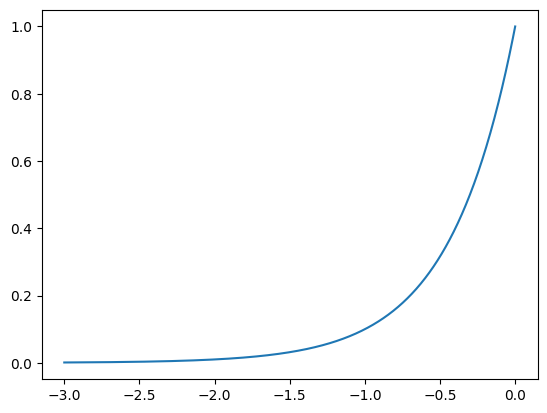

In [52]:
# determine good learning rate
# 1st determine range (0.001, 1)
# traverse the range exponentially, instead of linearly
#   low in the beginning, high in the end
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
plt.plot(lre, lrs)

In [53]:
lri = []
lossi = []

niter = 10000
lr = 0.1  # best learning rate determined experimentally
for i in range(niter):

  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))

  # forward pass
  emb = C[X[ix]]
  h = torch.tanh(emb.view(-1, emb.shape[1]*emb.shape[2]) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update parameters
  # lr = lrs[i]
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # lri.append(lre[i])  # learning rate
  # lossi.append(loss.item())  # loss
print(loss.item())

1.9479632377624512


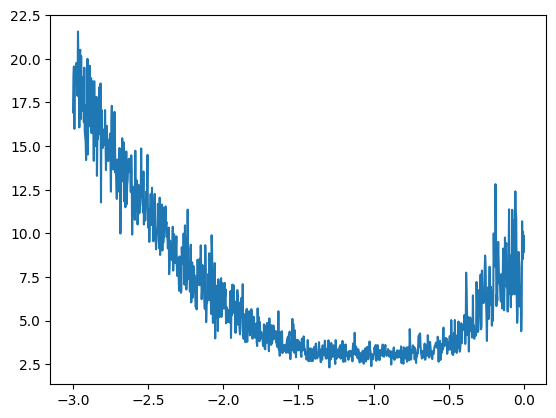

In [46]:
# plot to decide which learning rate is good
# roughly the minima comes at 10**-1 = 0.1
plt.plot(lri, lossi)

tensor([0.0010, 0.0022, 0.0046, 0.0100, 0.0215, 0.0464, 0.1000, 0.2154, 0.4642,
        1.0000])